In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt

In [2]:
#path to the data folder, edit if necesssary
path = "./data/"

#filenames
file_power = "competitor_market_prices_power.csv"
file_gas = "competitor_market_prices_gas.csv"
clean_power = "clean_competitor_market_prices_power.csv"
clean_gas = "clean_competitor_market_prices_gas.csv"


#Price Filenames
spot_gas = "eex_spot_gas.csv"
d_ahead_gas = "eex_gas_d.csv"
y_ahead_gas = "eex_gas_y.csv"

spot_power = "epex_spot_power.csv"
d_ahead_peak = "eex_power_peak_d.csv"
y_ahead_peak = "eex_power_peak_y.csv"
d_ahead_base = "eex_power_base_d.csv"
y_ahead_base = "eex_power_base_y.csv"

In [3]:
df_gas = pd.read_csv(path + clean_gas)
df_gas.drop(columns = ['Unnamed: 0'], inplace = True)
df_gas

,date_valid_to,date_valid_from,post_code,city,energy,consumption_range_kwh,supplier,tariff,rank,price_year_eur
0,2021-09-01,2021-05-21,1309,Dresden,gas,1000,Levante,Sawsbuck,1.0,131.30
1,2021-09-01,2021-05-21,1309,Dresden,gas,1500,Levante,Sawsbuck,1.0,160.95
2,2021-09-01,2021-05-21,1309,Dresden,gas,2000,Levante,Sawsbuck,1.0,190.60
3,2021-09-01,2021-05-21,1309,Dresden,gas,2300,Levante,Sawsbuck,1.0,208.39
4,2021-09-01,2021-05-21,1309,Dresden,gas,2500,Levante,Sawsbuck,1.0,220.25
...,...,...,...,...,...,...,...,...,...,...
18287483,9999-12-31,2022-10-15,99089,Erfurt,gas,500000,Belat,Carracosta,5.0,149087.87
18287484,9999-12-31,2022-10-15,99089,Erfurt,gas,500000,Pulenat,Araquanid,6.0,149525.13
18287485,9999-12-31,2022-10-15,99089,Erfurt,gas,500000,Pulenat,Perrserker,4.0,148990.13
18287486,9999-12-31,2022-10-15,99089,Erfurt,gas,500000,Sarma,Aegislash,2.0,145733.08


In [4]:
df_power = pd.read_csv(path + clean_power)
df_power.drop(columns = ['Unnamed: 0'], inplace = True)
df_power

,date_valid_to,date_valid_from,post_code,city,energy,consumption_range_kwh,supplier,tariff,rank,price_year_eur
0,2021-09-01,2021-06-02,14480,Potsdam,power,3500,Galerne,Skiploom,1.0,878.86
1,2021-09-01,2021-06-09,14480,Potsdam,power,2800,Galerne,Skiploom,1.0,678.69
2,2021-09-01,2021-07-10,14480,Potsdam,power,7500,Galerne,Skiploom,1.0,2022.68
3,2021-09-01,2021-07-10,14480,Potsdam,power,7800,Galerne,Skiploom,1.0,2108.47
4,2021-09-01,2021-07-10,14480,Potsdam,power,8000,Galerne,Skiploom,1.0,2165.66
...,...,...,...,...,...,...,...,...,...,...
33161801,9999-12-31,2022-10-15,99089,Erfurt,power,12000,Werra,Banette,9.0,9257.05
33161802,9999-12-31,2022-10-15,99089,Erfurt,power,12000,Werra,Meditite,12.0,9375.86
33161803,9999-12-31,2022-10-15,99089,Erfurt,power,20000,Lule älv,Pidove,7.0,15292.50
33161804,9999-12-31,2022-10-15,99089,Erfurt,power,20000,Sirkos,Magikarp,2.0,13567.83


In [5]:
#Joining Price Data
df_spot_power = pd.read_csv(path + spot_power, usecols = [0,1])
df_y_ahead_peak = pd.read_csv(path + y_ahead_peak, usecols = [0,1,2,3])
df_y_ahead_base = pd.read_csv(path + y_ahead_base, usecols = [0,1,2,3])
df_d_ahead_peak = pd.read_csv(path + d_ahead_peak, usecols = [0,1])
df_d_ahead_base = pd.read_csv(path + d_ahead_base, usecols = [0,1])

In [6]:
#Renaming columns
df_spot_power.rename(columns = {'d': 'spot'}, inplace = True)
df_y_ahead_peak.rename(columns = {'y01': 'y_ahead_peak',
                                 'y02': '2y_ahead_peak',
                                 'y03': '3y_ahead_peak'}, inplace = True)
df_y_ahead_base.rename(columns = {'y01': 'y_ahead_base',
                                 'y02': '2y_ahead_base',
                                 'y03': '3y_ahead_base'}, inplace = True)
df_d_ahead_peak.rename(columns = {'d00': 'd_ahead_peak'}, inplace = True)
df_d_ahead_base.rename(columns = {'d00': 'd_ahead_base'}, inplace = True)

df_y_ahead_base

,date,y_ahead_base,2y_ahead_base,3y_ahead_base
0,2022-10-13,424.00,268.01,185.24
1,2022-10-12,434.00,268.00,193.88
2,2022-10-11,435.64,270.00,194.92
3,2022-10-10,427.00,270.00,195.00
4,2022-10-09,427.00,270.00,195.00
...,...,...,...,...
1993,2017-04-29,NaN,NaN,NaN
1994,2017-04-28,29.63,27.50,27.54
1995,2017-04-27,29.41,27.32,27.46
1996,2017-04-26,29.35,27.22,27.31


In [7]:
#Indexing Spot Price Data
df_spot_power.time = pd.to_datetime(df_spot_power.time)
df_spot_power['Dates'] = df_spot_power['time'].dt.date
df_spot_power.set_index('time', inplace = True)

In [8]:
#Generating Daily Peak and Base Prices
df_spot_power_peak = df_spot_power.between_time("08:00", "19:59")
#df_spot_power_base = df_spot_power.between_time("20:00", "07:59")
df_spot_power_base = df_spot_power.groupby('Dates').mean()
df_spot_power_peak = df_spot_power_peak.groupby('Dates').mean()

#Renaming the columns and joining
df_spot_power_peak.rename(columns = {'spot': 'spot_peak'}, inplace = True)
df_spot_power_base.rename(columns = {'spot': 'spot_base'}, inplace = True)

#Joining the dataset
df_spot_power = pd.merge(df_spot_power_peak,df_spot_power_base, how='inner', left_index=True, right_index=True)
#df_spot_power['date'] = pd.to_datetime(df_spot_power.index)


In [9]:
#Joining all price data into master data
from datetime import datetime, timedelta

#Setting join date as index for joining to avoid lookahead bias
df_power.date_valid_from = pd.to_datetime(df_power.date_valid_from)
df_power.index = df_power.date_valid_from - timedelta(days = 1)


#Joining all price data
power_price_dfs = [df_y_ahead_peak, df_y_ahead_base, df_d_ahead_peak, df_d_ahead_base]

for df in power_price_dfs:
    df.set_index(pd.to_datetime(df.date), inplace = True)
    df.drop(columns = ['date'], inplace = True)
    df_spot_power = df_spot_power.join(df)
    
df_power_prices = df_spot_power
    
df_power_prices

,spot_peak,spot_base,y_ahead_peak,2y_ahead_peak,3y_ahead_peak,y_ahead_base,2y_ahead_base,3y_ahead_base,d_ahead_peak,d_ahead_base
Dates,,,,,,,,,,
2000-06-16,20.503333,17.126250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-06-17,15.180000,13.297083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-06-18,12.578333,11.401667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-06-19,21.919167,17.666250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-06-20,22.856667,18.363750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-10-10,186.518333,162.090000,581.64,353.67,254.50,427.00,270.00,195.00,186.52,162.09
2022-10-11,291.780833,259.873750,585.40,355.50,253.50,435.64,270.00,194.92,291.78,259.87
2022-10-12,299.796667,282.535833,590.00,355.46,253.61,434.00,268.00,193.88,299.80,282.54


In [10]:
#Joining all prices with df_power
df_power = df_power.join(df_power_prices)

In [11]:
df_power

,date_valid_to,date_valid_from,post_code,city,energy,consumption_range_kwh,supplier,tariff,rank,price_year_eur,spot_peak,spot_base,y_ahead_peak,2y_ahead_peak,3y_ahead_peak,y_ahead_base,2y_ahead_base,3y_ahead_base,d_ahead_peak,d_ahead_base
2021-05-24,2021-09-21,2021-05-25,51103,Köln,power,500,Criador,Meltan,3.0,260.25,26.460833,31.645417,74.6,72.05,70.45,64.2,61.08,59.28,26.46,31.65
2021-05-24,2021-09-21,2021-05-25,51381,Leverkusen,power,500,Criador,Meltan,3.0,257.85,26.460833,31.645417,74.6,72.05,70.45,64.2,61.08,59.28,26.46,31.65
2021-05-24,2021-09-21,2021-05-25,51469,Bergisch Gladbach,power,500,Criador,Meltan,3.0,257.85,26.460833,31.645417,74.6,72.05,70.45,64.2,61.08,59.28,26.46,31.65
2021-05-24,2021-09-22,2021-05-25,51103,Köln,power,250,Criador,Meltan,3.0,187.62,26.460833,31.645417,74.6,72.05,70.45,64.2,61.08,59.28,26.46,31.65
2021-05-24,2021-09-22,2021-05-25,51381,Leverkusen,power,250,Criador,Meltan,2.5,186.42,26.460833,31.645417,74.6,72.05,70.45,64.2,61.08,59.28,26.46,31.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-14,9999-12-31,2022-10-15,99089,Erfurt,power,12000,Werra,Banette,9.0,9257.05,283.841667,260.645833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-14,9999-12-31,2022-10-15,99089,Erfurt,power,12000,Werra,Meditite,12.0,9375.86,283.841667,260.645833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-14,9999-12-31,2022-10-15,99089,Erfurt,power,20000,Lule älv,Pidove,7.0,15292.50,283.841667,260.645833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-14,9999-12-31,2022-10-15,99089,Erfurt,power,20000,Sirkos,Magikarp,2.0,13567.83,283.841667,260.645833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
#Getting gas price data
df_spot_gas = pd.read_csv(path + spot_gas, usecols = [0,1])
df_y_ahead_gas = pd.read_csv(path + y_ahead_gas, usecols = [0,1,2,3])
df_d_ahead_gas = pd.read_csv(path + d_ahead_base, usecols = [0,1])

In [13]:
#Renaming columns
df_spot_gas.rename(columns = {'d': 'spot'}, inplace = True)
df_y_ahead_gas.rename(columns = {'y01': 'y_ahead_gas',
                                'y02': '2y_ahead_gas',
                                'y03': '3y_ahead_gas'}, inplace = True)
df_d_ahead_gas.rename(columns = {'d00': 'd_ahead_gas'}, inplace = True)

In [14]:
df_spot_gas

,date,spot
0,2022-10-14,98.389
1,2022-10-13,105.416
2,2022-10-12,106.853
3,2022-10-11,105.449
4,2022-10-10,119.323
...,...,...
4150,2011-06-04,22.960
4151,2011-06-03,22.990
4152,2011-06-02,23.170
4153,2011-06-01,22.790


In [15]:
#Joining all gas price data into competitor dataset
from datetime import datetime, timedelta

#Setting join date as index for joining to avoid lookahead bias
df_gas.date_valid_from = pd.to_datetime(df_gas.date_valid_from)
df_gas.index = df_gas.date_valid_from - timedelta(days = 1)
df_gas

,date_valid_to,date_valid_from,post_code,city,energy,consumption_range_kwh,supplier,tariff,rank,price_year_eur
date_valid_from,,,,,,,,,,
2021-05-20,2021-09-01,2021-05-21,1309,Dresden,gas,1000,Levante,Sawsbuck,1.0,131.30
2021-05-20,2021-09-01,2021-05-21,1309,Dresden,gas,1500,Levante,Sawsbuck,1.0,160.95
2021-05-20,2021-09-01,2021-05-21,1309,Dresden,gas,2000,Levante,Sawsbuck,1.0,190.60
2021-05-20,2021-09-01,2021-05-21,1309,Dresden,gas,2300,Levante,Sawsbuck,1.0,208.39
2021-05-20,2021-09-01,2021-05-21,1309,Dresden,gas,2500,Levante,Sawsbuck,1.0,220.25
...,...,...,...,...,...,...,...,...,...,...
2022-10-14,9999-12-31,2022-10-15,99089,Erfurt,gas,500000,Belat,Carracosta,5.0,149087.87
2022-10-14,9999-12-31,2022-10-15,99089,Erfurt,gas,500000,Pulenat,Araquanid,6.0,149525.13
2022-10-14,9999-12-31,2022-10-15,99089,Erfurt,gas,500000,Pulenat,Perrserker,4.0,148990.13


In [16]:
#Joining all price data
df_spot_gas.set_index('date', inplace = True)
df_y_ahead_gas.set_index('date', inplace = True)
df_d_ahead_gas.set_index('date', inplace = True)

#Joining all price data
gas_price_dfs = [df_y_ahead_gas, df_d_ahead_gas]

df_gas_prices = df_spot_gas

for df in gas_price_dfs:
    df_gas_prices = df_gas_prices.join(df)
    
df_gas_prices.index = pd.to_datetime(df_gas_prices.index)

In [17]:
df_gas = df_gas.join(df_gas_prices)
df_gas

,date_valid_to,date_valid_from,post_code,city,energy,consumption_range_kwh,supplier,tariff,rank,price_year_eur,spot,y_ahead_gas,2y_ahead_gas,3y_ahead_gas,d_ahead_gas
2021-05-20,2021-09-01,2021-05-21,1309,Dresden,gas,1000,Levante,Sawsbuck,1.0,131.30,23.128,NaN,NaN,NaN,69.99
2021-05-20,2021-09-01,2021-05-21,1309,Dresden,gas,1500,Levante,Sawsbuck,1.0,160.95,23.128,NaN,NaN,NaN,69.99
2021-05-20,2021-09-01,2021-05-21,1309,Dresden,gas,2000,Levante,Sawsbuck,1.0,190.60,23.128,NaN,NaN,NaN,69.99
2021-05-20,2021-09-01,2021-05-21,1309,Dresden,gas,2300,Levante,Sawsbuck,1.0,208.39,23.128,NaN,NaN,NaN,69.99
2021-05-20,2021-09-01,2021-05-21,1309,Dresden,gas,2500,Levante,Sawsbuck,1.0,220.25,23.128,NaN,NaN,NaN,69.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-14,9999-12-31,2022-10-15,99089,Erfurt,gas,500000,Belat,Carracosta,5.0,149087.87,98.389,NaN,NaN,NaN,NaN
2022-10-14,9999-12-31,2022-10-15,99089,Erfurt,gas,500000,Pulenat,Araquanid,6.0,149525.13,98.389,NaN,NaN,NaN,NaN
2022-10-14,9999-12-31,2022-10-15,99089,Erfurt,gas,500000,Pulenat,Perrserker,4.0,148990.13,98.389,NaN,NaN,NaN,NaN
2022-10-14,9999-12-31,2022-10-15,99089,Erfurt,gas,500000,Sarma,Aegislash,2.0,145733.08,98.389,NaN,NaN,NaN,NaN


In [18]:
#Creating Supplier Strategy Index (Index 1 - 5 and 5 for suppliers showing up in the top 50 less than 10000 times)
gas_suppliers = df_gas[['supplier', 'rank']]
power_suppliers = df_power[['supplier', 'rank']]
gas_suppliers

,supplier,rank
2021-05-20,Levante,1.0
2021-05-20,Levante,1.0
2021-05-20,Levante,1.0
2021-05-20,Levante,1.0
2021-05-20,Levante,1.0
...,...,...
2022-10-14,Belat,5.0
2022-10-14,Pulenat,6.0
2022-10-14,Pulenat,4.0
2022-10-14,Sarma,2.0


In [19]:
#Valid suppliers
gas_sup_counts = pd.DataFrame(gas_suppliers['supplier'].value_counts())
pow_sup_counts = pd.DataFrame(power_suppliers['supplier'].value_counts()) 
no_strat_gas_suppliers = gas_sup_counts.loc[gas_sup_counts.supplier < 10000]
no_strat_pow_suppliers = pow_sup_counts.loc[pow_sup_counts.supplier < 10000]

(array([ 0.,  3.,  2.,  3.,  0.,  8.,  7.,  9., 17.,  8.,  8., 12.,  9.,
         5.,  7.,  3.,  3.,  1.,  0.,  0.]),
 array([ 1.  ,  3.45,  5.9 ,  8.35, 10.8 , 13.25, 15.7 , 18.15, 20.6 ,
        23.05, 25.5 , 27.95, 30.4 , 32.85, 35.3 , 37.75, 40.2 , 42.65,
        45.1 , 47.55, 50.  ]),
 <BarContainer object of 20 artists>)

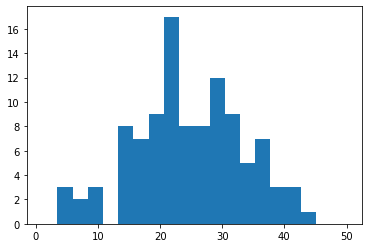

In [20]:


average_gas_ranks = pd.DataFrame(df_gas.loc[~df_gas['supplier'].isin(no_strat_gas_suppliers.index)].groupby('supplier')['rank'].mean())
average_power_ranks = pd.DataFrame(df_power.loc[~df_power['supplier'].isin(no_strat_pow_suppliers.index)].groupby('supplier')['rank'].mean())


#plt.hist(average_gas_ranks, range = (1, 50), bins = 20)
plt.hist(average_power_ranks, range = (1, 50), bins = 20)


In [21]:
bins = [1,2,3,4,5]
cutoffs = [0, 9, 19, 29, 39, 49]
average_gas_ranks['strat_index'] = pd.cut(average_gas_ranks['rank'], bins = cutoffs, labels = bins)
average_power_ranks['strat_index'] = pd.cut(average_power_ranks['rank'], bins = cutoffs, labels = bins)

In [22]:
#Adding Strategy Indices to Datasets
df_power = df_power.merge(average_power_ranks[['strat_index']], how = 'left', left_on = 'supplier', right_on = average_power_ranks.index)
df_gas = df_gas.merge(average_gas_ranks[['strat_index']], how = 'left', left_on = 'supplier', right_on = average_gas_ranks.index)

In [23]:
#Filling Strategy Index NAs with index value 5, since they are outside of the top 50 for most postcodes
df_power['strat_index'] = df_power['strat_index'].fillna(5)
df_gas['strat_index'] = df_gas['strat_index'].fillna(5)

In [24]:
#Replacing invalid date_valid_to dates with max date in date_valid_from
max_valid_to = df_power.date_valid_from.max()
df_gas['date_valid_to'] = df_gas['date_valid_to'].str.replace('9999-12-31', str(max_valid_to))
df_power['date_valid_to'] = df_power['date_valid_to'].str.replace('9999-12-31', str(max_valid_to))

#Converting validity dates to datetimes
df_gas['date_valid_to'] = pd.to_datetime(df_gas['date_valid_to'])
df_power['date_valid_to'] = pd.to_datetime(df_power['date_valid_to'])

#Building validity period features
df_gas['validity_period'] = df_gas['date_valid_to'] - df_gas['date_valid_from']
df_power['validity_period'] = df_power['date_valid_to'] - df_power['date_valid_from']

In [25]:
df_gas.to_csv(path + "master_" + file_gas)
df_power.to_csv(path + "master_" + file_power)